# 프로젝트
## : 네이버 영화리뷰 감성 분석 도전하기

### 한국어 텍스트 감성 분석 진행

---------------------

### 1) 프로젝트 준비와 확인

In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import os
import matplotlib as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/EX6/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/EX6/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(len(train_data))
print(train_data.isnull().values.any())


150000
True


In [3]:
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')
# Null 값이 존재하는지 확인
print(train_data.isnull().values.any()) 
print(len(train_data))

False
149995


#### isnull().values.any() 
: 결측치를 확인하는 메서드

#### .dropna(how = 'any')
 :NaN value가 존재하는 행(row) 또는 열(column)을 제거
  
    -how = 'any'/'all'
        *any -> row 또는 column에 NaN값이 1개만 있어도 drop (default 값입니다.)
        *all -> row 또는 column에 있는 모든 값이 NaN이어야 drop
        

### 2) 데이터로 구성



                
#### data_loader() 
                
      * 데이터의 중복 제거
      * NaN 결측치 제거
      * 한국어 토크나이저로 토큰화
      * 불용어(Stopwords) 제거
      * 사전word_to_index 구성
      * 텍스트 스트링을 사전 인덱스 스트링으로 변환
      * X_train, y_train, X_test, y_test, word_to_index 리턴 
           
           


In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','...','..','ㅜㅜ']

def load_data(train_data, test_data, num_words=10000):
    #데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    #결측치 제거
    train_data = train_data.dropna(how = 'any') 
    
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화후 텍스트 형태로 반환함
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        # 불용어 리스트에 있는 단어와 word가 같지 않으면 temp_X리스트에 단어 저장
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### Mecab() 
: 형태소 분석기
#### if not:
:결과가 0이면 아래 문장을 실행
#### morphs( text )
:텍스트에서 형태소를 반환한다

#### np.concatenate
:데이터 결합
#### .tolist()
같은 레벨(위치)에 있는 데이터들끼리 묶어줌
#### most_common() 
: 최빈값을 구해줌


### 3.모델 구성을 위한 데이터 분석 및 가공
    * 데이터셋 내 문장 길이 분포
    * 적절한 최대 문장 길이 지정
    * keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.772713078289538
문장길이 최대 :  116
문장길이 표준편차 :  12.74251533152831
pad_sequences maxlen :  41
전체 문장의 0.9356605695739202%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
        #padding='post' : 뒷부분애 0을 채워서 길이를 맞춤
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


###  tf.keras.preprocessing.sequence.

    -class TimeseriesGenerator: 임시 데이터 배치를 생성하기 위한 유틸리티 클래스
    
        * make_sampling_table(...): 단어 순위 기반 확률적 샘플링 테이블을 생성

        * pad_sequences(...): 시퀀스를 동일한 길이로 채움

        * skipgrams(...): skipgram 단어 쌍을 생성


    
 ### tf.keras.layers.Embedding( ) 
    - input_dim      
      : 정수 > 0. 어휘목록의 크기, 다시 말해, 최대 정수 색인 + 1.

    - output_dim   
      : 정수 >= 0. 밀집 임베딩의 차원.

    - input_length 
      : 인풋 시퀀스의 길이로 상위 Dense 레이어와 Flatten 레이어를 연결하려면 
        이 인수가 필요 (그렇지 않고서는 밀집 아웃풋의 형태를 계산할 수 없습니다).
[출처] # [ML/DL] 대용량 데이터 처리 - COO matrix, Embedding|작성자 키아

### 4) 모델 구성 및 validation set 구성
    -3가지 이상 다양한 모델 실험하기

### RNN (Recurrent Neural Network)
    : 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델
        - 시퀀스 데이터  : 입력이 시간 축을 따라 발생하는 데이터
        
        3초에 걸쳐 이 문장을 발음했음
        
        at time=0s : 듣는이의 귀에 들어온 input='i'
        at time=1s : 듣는이의 귀에 들어온 input='feel'
        at time=2s : 듣는이의 귀에 들어온 input='hungry'
        
    : 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는
    state machine으로 설계
    
    @ State machine
    : 음성인식, 자연어등에 사용됨
        
        

In [10]:
# validation set 50000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 96182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [11]:
#1-D Convolution Neural Network(1
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
GlobalMaxPooling1D()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
227/227 [==============================] - 2s 4ms/step - loss: 0.5889 - accuracy: 0.7440 - val_loss: 0.4419 - val_accuracy: 0.8237
Epoch 2/4
227/227 [==============================] - 1s 4ms/step - loss: 0.3855 - accuracy: 0.8404 - val_loss: 0.3646 - val_accuracy: 0.8404
Epoch 3/4
227/227 [==============================] - 1s 3ms/step - loss: 0.3296 - accuracy: 0.8634 - val_loss: 0.3509 - val_accuracy: 0.8457
Epoch 4/4
227/227 [==============================] - 1s 4ms/step - loss: 0.2997 - accuracy: 0.8772 - val_loss: 0.3503 - val_accuracy: 0.8475


In [15]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3605 - accuracy: 0.8435
[0.3604949414730072, 0.843521773815155]


In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) loss, Accuracy 그래프 시각화

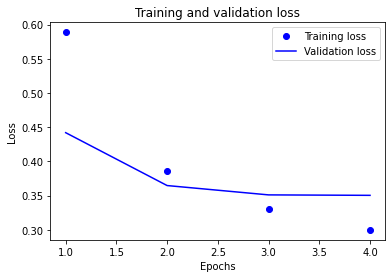

In [17]:
from matplotlib import pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

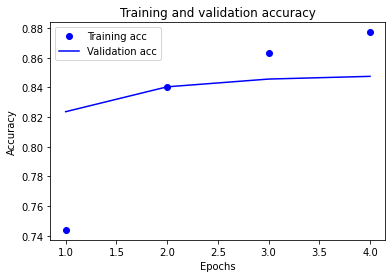

In [18]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7)학습된 Embedding 레이어 분석

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

    - 한국어 Word2Vec 보기
    : https://github.com/Kyubyong/wordvectors
     -> 위 링크에서 적절한 ko.bin을 찾아 사용하기 & gensim 버전을 3.X.X로 낮춰야 오류가 나지 않음

In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/EX6/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-6, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(6,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사람']
vector

array([-0.07088202,  0.17760898, -0.09736626,  0.16699834, -0.05682815,
       -0.00603874, -0.08773124, -0.11920564, -0.0453076 , -0.0970065 ,
       -0.07316636, -0.05074143,  0.1818702 , -0.10636187, -0.11409357,
       -0.05413335], dtype=float32)

In [22]:
word_vectors.similar_by_word("마동석")

[('소리지르', 0.8766074776649475),
 ('웃겨서', 0.8725901246070862),
 ('세라', 0.868360698223114),
 ('느껴져서', 0.8597697019577026),
 ('미지근', 0.8553661704063416),
 ('매니아', 0.8536591529846191),
 ('이뻤', 0.8531113862991333),
 ('소란', 0.8405031561851501),
 ('강소라', 0.8379554152488708),
 ('대인', 0.8369402885437012)]

In [23]:
word_vectors.similar_by_word("어벤져스")

[('원인', 0.8383848071098328),
 ('감추', 0.8373436331748962),
 ('일요일', 0.813671350479126),
 ('증언', 0.8110938668251038),
 ('임상수', 0.8102012276649475),
 ('찝찝', 0.8051401376724243),
 ('논', 0.804187536239624),
 ('설원', 0.7947749495506287),
 ('어떤지', 0.7934657335281372),
 ('렉', 0.789051353931427)]

### 다른 모델을 이용해서 훈련하기
### 1-D Convolution Neural Network(1-D CNN)

# 회고
사실 이번노드는 코드를 어떻게 짜야하는지 몰라서 동기분의 도움을 받아 코드를 작성할 수 있었다. 코드 자체를 모르니 어떤부분이 잘못되서 에러가 나는지도 알수 없었다. 그래서 코드는 동기분의 도움을 받아 작성하고 그 코드를 이해하는 것에 이번 프로젝트에 목표로 삼았다.
코드를 분석하고 정리하면서 왜 이렇게 코드가 구성되었고 어떤 메서드들을 쓰고 그 메서드가 어떤 기능을 하는지 알수 있게 되었다.


1-D Convolution Neural Network(1)결과
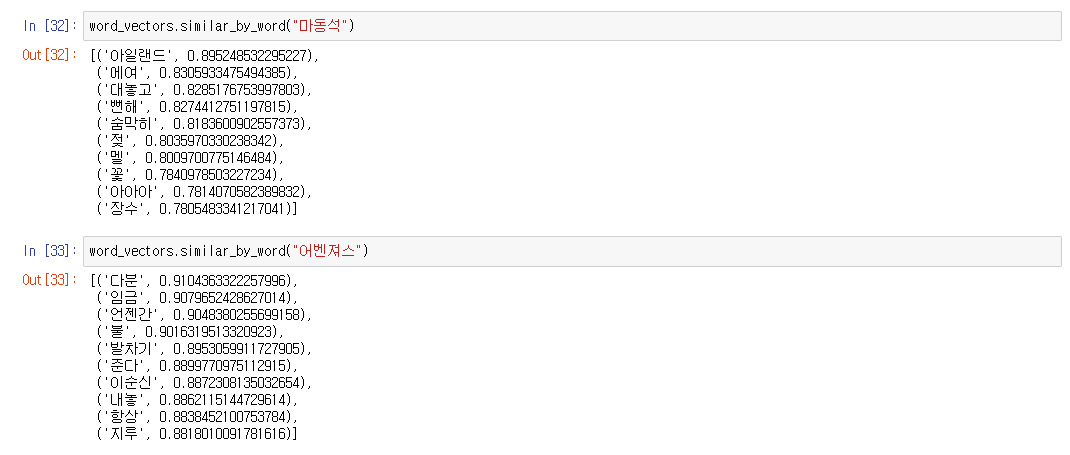

 RNN 결과
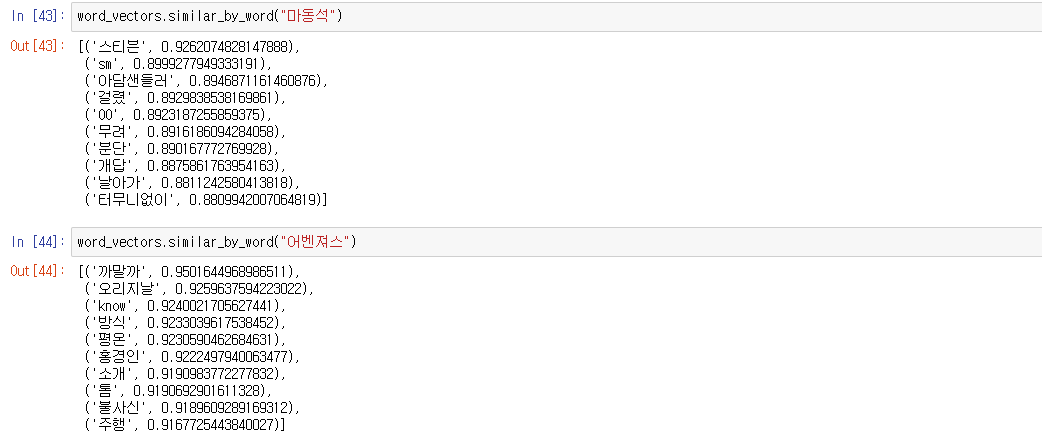

GlobalMaxPooling1D() 결과
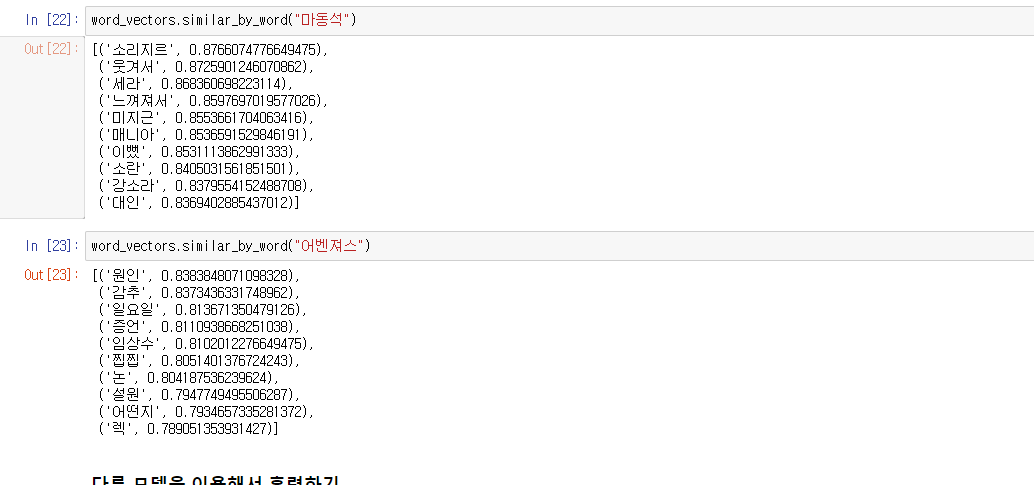